<table>
<tr><td><img style="height: 150px;" src="images/geo_hydro1.jpg"></td>
<td bgcolor="#FFFFFF">
    <p style="font-size: xx-large; font-weight: 900; line-height: 100%">AG Dynamics of the Earth</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Jupyter notebooks</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Georg Kaufmann</p>
    </td>
</tr>
</table>

# Geophysikalisches Praktikum: Electrical resistivity imaging

## Reading and plotting ERT data
----
*Georg Kaufmann,
Geophysics Section,
Institute of Geological Sciences,
Freie Universität Berlin,
Germany*



In this notebook, we will discuss and then read data files (topography, ERT data) 
saved in the `geodyn5` format.
<img src="images/BlaueKuppe_ERT02_Wenner.png" style="height:10cm">

First, we load some `python` libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import scipy.interpolate
import scipy.spatial

import libGP
libGP.change_fontsize()

----
## Reading a geodyn5 file

Our first script will be used to **read** a dataset of ERT data, 
which has been saved in the geodyn5 format. Below, the first lines from the
file `2Dc_GP2022_ERT01_Wenner.xz` are shown:

The first lines (starting with an exclamation mark) are **meta-data** of the dataset,
describing its content, technial details such as the source, the coordinate system:
- !PROJECT - project name
- !DATA:        - name of dtaa set
- !OPERATOR: - operator names
- !DATE:   - date of data set (creation)
- !COORDINATES: - coordinates
- !NOTES:       - note 

This list is not exclusive, you can assign your own meta-data, as long as they start with an exclamation mark.

The last two rows of meta-data describe the structure of the following data set, the `geodyn5` dataset.
The column entries for the dtaa set (mandatory) are:
- datetime - datetime string for data point [yyyy-mm-dd-hh:mm:ss]
- easting  - easting coordinate [m]
- northing - northing coordinate [m]
- elev     - elevation [m]
- depth    - depth value for resistivity below ground [m]
- field1   - specific resistivity [Ohm m]
- field2   - profile distance [m]

We will read this data file with the following script below.

We open the data file (in the data directiry) as `infile1`, read all content into the
variable `lines`, then loop over all lines stored in `lines`and sort for meta-data and data.

- meta-data: are printed as info
- data: each data line is splitted into parts and saved as `python` list for
the lists datetime, easting, northing, elev, offset, field1, field2.

In [3]:
# read ert data files
profile = 'ERT02_Schlumberger'

infile_total1 = 'data/FUGeocampus/2Dc_GP2021_'+profile+'.xz'
file_ert = open(infile_total1, 'r')
ertlines = file_ert.readlines()
file_ert.close()

In [4]:
# create ert data fields (easting, northing, elev/boug)
imeta=0; iertdata=0
datetime =[]
ert = np.empty((0,6))

for line in ertlines:
    # Get next line from file
    if (line[0] == '!'):
        imeta += 1
        #print(line.split())
    else:
        iertdata += 1
        add  = np.array([[float(line.split()[1]),
                          float(line.split()[2]),
                          float(line.split()[3]),
                          float(line.split()[4]),
                          float(line.split()[5]),
                          float(line.split()[6])]])
        ert = np.append(ert,add,axis=0)
        datetime.append(line.split()[0])
        
print('Number of meta-data lines: ',imeta)
print('Number of ert lines:       ',iertdata)
print('min/max elevation:         ',ert[:,2].min(),ert[:,2].max())
print('min/max offset:            ',ert[:,3].min(),ert[:,3].max())
print('min/max resistivity:       ',ert[:,4].min(),ert[:,4].max())
print('min/max profile:           ',ert[:,5].min(),ert[:,5].max())
print(ert.shape)

Number of meta-data lines:  15
Number of ert lines:        120
min/max elevation:          43.78 44.05
min/max offset:             -14.4 -0.75
min/max resistivity:        50.78 1010.7
min/max profile:            4.5 67.5
(120, 6)


----
## Triangulation

Plot resistivity points first to check layout ...

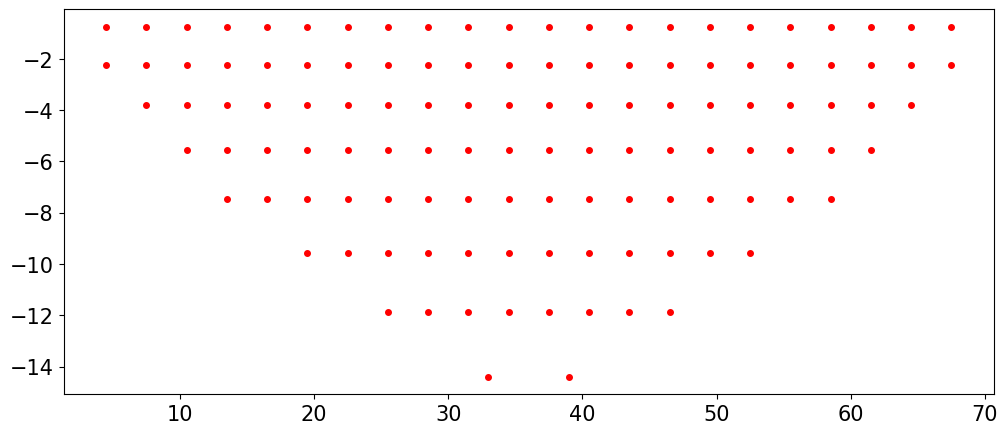

In [5]:
plt.figure(figsize=(12,5))
plt.plot(ert[:,5],ert[:,3], 'o',markersize=4,color='red')

Then group profile and offset coordinates into 2D points array, then triangulate ...

In [6]:
points = np.zeros(ert.shape[0]*2).reshape(ert.shape[0],2)
for i in range(ert.shape[0]):
    points[i][0] = ert[i,5]
    points[i][1] = ert[i,3]
print(points.shape)

tri = scipy.spatial.Delaunay(points)
print(tri.points.shape)
print(tri.simplices.shape)

(120, 2)
(120, 2)
(208, 3)


Plot triangulation ...

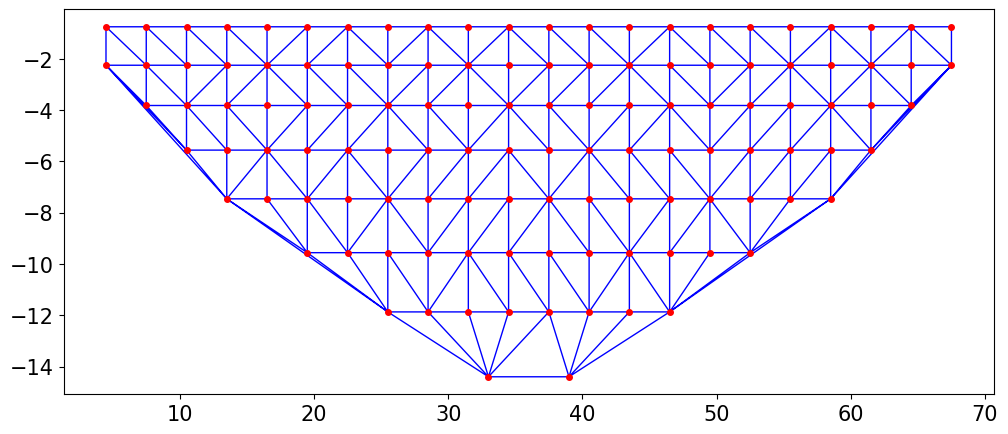

In [7]:
plt.figure(figsize=(12,5))
plt.plot(points[:,0], points[:,1], 'o',markersize=4,color='red')
plt.triplot(points[:,0], points[:,1], tri.simplices,linewidth=1,color='blue')

Finally, add elevation to offset points to shift the triangles to the geographically
correct position, and color-code the triangles (by value of edges!).

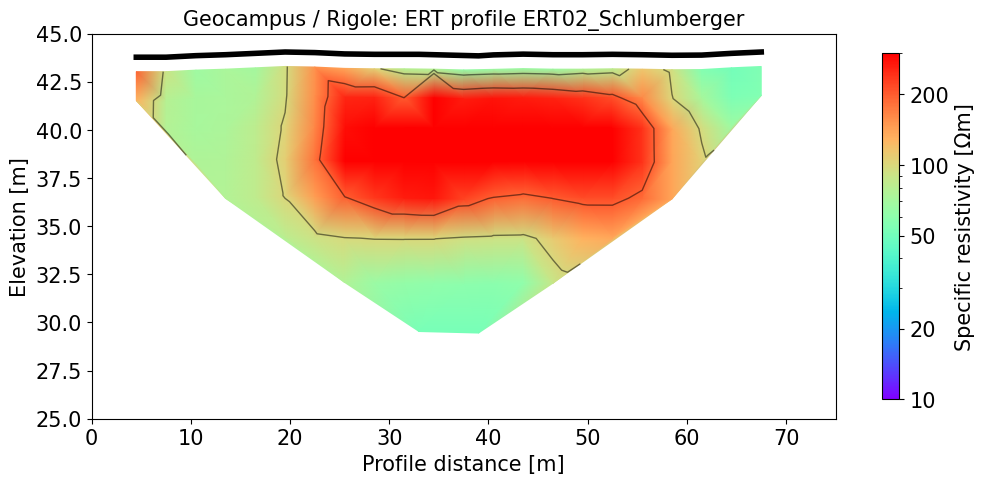

In [11]:
# plot ERT profile
from matplotlib.ticker import LogFormatter 
fig,ax1 = plt.subplots(1,1,figsize=(12.0, 5.0))

ax1.set_xlabel('Profile distance [m]')
ax1.set_ylabel('Elevation [m]')
ax1.set_title('Geocampus / Rigole: ERT profile '+profile)
ax1.set_xlim([0,75])
#ax1.set_ylim([260,310])
ax1.set_ylim([25,45])

sorted = np.argsort(ert[:,5])
ax1.plot(ert[sorted,5],ert[sorted,2],linewidth=4,color='black')
plt.tricontour(points[:,0], points[:,1]+ert[:,2], tri.simplices,ert[:,4],levels=[20,50,100,200],
              colors='black',alpha=0.5,linewidths=1)
im1 = plt.tripcolor(points[:,0], points[:,1]+ert[:,2], tri.simplices,ert[:,4], shading='gouraud',
                    cmap = plt.get_cmap('rainbow'),norm=matplotlib.colors.LogNorm(vmin=10,vmax=300))
formatter = LogFormatter(10, labelOnlyBase=False,minor_thresholds=(3,2)) 
cbar1=fig.colorbar(im1,ax=ax1,shrink=0.9,ticks=[10,20,50,100,200,500],format=formatter)
cbar1.set_label('Specific resistivity [\u03A9'+'m]', rotation=90)
plt.savefig("images/Geocampus_Rigole_"+profile+".png")

... done